In [13]:
import pandas
import matplotlib.pyplot as plt
import numpy as np



# Load INS data
ins_data = pandas.read_csv('csv/3-vectornav-ins.csv')
ins_data = ins_data.drop(columns=['.header.stamp.secs','.header.stamp.nsecs'])
ins_data['time'] = pandas.to_datetime(ins_data['time'])
ins_data['time'] = (ins_data['time'] - ins_data['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
ins_data = ins_data.set_index('time')

# Load GPS Fix (raw) data
fix_data = pandas.read_csv('csv/3-vectornav-fix.csv')
fix_data = fix_data.drop(columns=['.header.stamp.secs','.header.stamp.nsecs'])
fix_data['time'] = pandas.to_datetime(fix_data['time'])
fix_data['time'] = (fix_data['time'] - fix_data['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
fix_data = fix_data.set_index('time')



# Load IMU Data
imu_data = pandas.read_csv('csv/3-vectornav-imu.csv') 
imu_data = imu_data.drop(columns=['.header.stamp.secs','.header.stamp.nsecs'])
imu_data['time'] = pandas.to_datetime(imu_data['time'])
imu_data['time'] = (imu_data['time'] - imu_data['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
imu_data = imu_data.set_index('time')

    

# Load Pacmod Speed Data
# pacmod parsed_txt/vehicle_speed is gets corrupt rows, so we will use as_tx/vehicle_speed
pacmod_speed = pandas.read_csv('csv/3-pacmod-as_tx-vehicle_speed.csv')
pacmod_speed['time'] = pandas.to_datetime(pacmod_speed['time'])
pacmod_speed['time'] = (pacmod_speed['time'] - pacmod_speed['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
# Additionally, there is an factor offset between parsed_txt/vehicle_speed and as_tx/vehicle_speed for whatever reason
# Use 2.237
pacmod_speed['.data'] = pacmod_speed['.data']*2.237
pacmod_speed = pacmod_speed.set_index('time')

# Load Pacmod Steer Data
pacmod_steer = pandas.read_csv('csv/3-pacmod-parsed_tx-steer_rpt.csv')
pacmod_steer = pacmod_steer.drop(columns=['.header.stamp.secs','.header.stamp.nsecs'])
pacmod_steer['time'] = pandas.to_datetime(pacmod_steer['time'])
pacmod_steer['time'] = (pacmod_steer['time'] - pacmod_steer['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
pacmod_steer = pacmod_steer.set_index('time')


# Add some basic calculations to dataframes ...

# Mangitude of speed
ins_data['.mag_speed'] = (ins_data['.NedVel.y']**2 + ins_data['.NedVel.x']**2)**(1/2)

# Add ins speed to IMU dataframe 
imu_data['ins_vel'] = 0.0
for t in imu_data.index:
    imu_data.at[t,'ins_vel'] = ins_data.iloc[ins_data.index.get_loc(t,method='nearest')]['.mag_speed']
    

# ENU Frame - subtract 90 from yaw
yaw = (90 - ins_data['.RPY.z']) * np.pi/180
ins_x_vel = ins_data['.NedVel.y'] 
ins_y_vel = ins_data['.NedVel.x'] 

# Local velocity at IMU location
ins_data['.LocalVel.x'] = np.multiply(ins_x_vel,np.cos(yaw)) + np.multiply(ins_y_vel,np.sin(yaw))
ins_data['.LocalVel.y'] = -np.multiply(ins_x_vel,np.sin(yaw)) + np.multiply(ins_y_vel,np.cos(yaw))
del yaw, ins_x_vel, ins_y_vel # clear unused variables
imu_data

,.header.seq,.header.frame_id,.gps_time,.Mag.x,.Mag.y,.Mag.z,.Accel.x,.Accel.y,.Accel.z,.Gyro.x,.Gyro.y,.Gyro.z,.Temp,.Pressure,ins_vel
time,,,,,,,,,,,,,,,
0.000000,0,vectornav,1.266946e+09,0.0,0.0,0.0,-0.094453,-0.340228,-9.736548,0.000916,-0.001054,-0.000949,0.0,0.0,0.008869
0.019953,1,vectornav,1.266946e+09,0.0,0.0,0.0,-0.120567,-0.356488,-9.767966,0.000109,-0.001250,-0.000148,0.0,0.0,0.008666
0.042105,2,vectornav,1.266946e+09,0.0,0.0,0.0,-0.141750,-0.369636,-9.781769,0.001173,0.000574,0.000459,0.0,0.0,0.008481
0.059909,3,vectornav,1.266946e+09,0.0,0.0,0.0,-0.130194,-0.343265,-9.799454,0.002330,-0.000922,-0.000619,0.0,0.0,0.008286
0.080888,4,vectornav,1.266946e+09,0.0,0.0,0.0,-0.133211,-0.353518,-9.813135,-0.000484,0.000951,-0.000802,0.0,0.0,0.008350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101.699659,5085,vectornav,1.266946e+09,0.0,0.0,0.0,-0.463178,-0.045410,-9.736493,0.000661,-0.000672,0.001059,0.0,0.0,0.019939
101.719661,5086,vectornav,1.266946e+09,0.0,0.0,0.0,-0.469636,-0.034508,-9.736650,-0.001906,-0.000532,-0.000766,0.0,0.0,0.019939
101.739668,5087,vectornav,1.266946e+09,0.0,0.0,0.0,-0.463734,-0.027328,-9.765305,-0.001424,0.000015,0.000670,0.0,0.0,0.019939


In [14]:
predicted_yaw = [ins_data['.RPY.z'][0]* np.pi/180] # Initialize first heading value to INS heading

for steering,time in zip(pacmod_steer['.manual_input'],pacmod_steer.index):
    V = pacmod_speed.iloc[pacmod_speed.index.get_loc(time,method='nearest')]['.data']
    prediction = predicted_yaw[-1] - (V/3.4)*np.tan(steering/20.0)*0.033 # updated equation. 
    prediction = (prediction + np.pi) % (2* np.pi) - np.pi # Wrap to pi
    predicted_yaw.append(prediction)



In [15]:
imu_yaw = [ins_data['.RPY.z'][0]* np.pi/180] # Initialize first heading value to INS heading
for i in range(imu_data.index.size - 1):
    t0 = imu_data.index[i]
    t1 = imu_data.index[i+1]
    y0 = imu_data['.Gyro.z'].iloc[i]
    integration = imu_yaw[-1] + (y0)*(t1-t0)
    integration = (integration + np.pi) % (2* np.pi) - np.pi # Wrap to pi
    imu_yaw.append(integration)


## Integrating Yaw

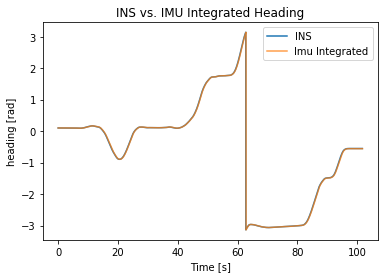

In [16]:
plt.figure()
plt.plot(ins_data.index.values,ins_data['.RPY.z'] * np.pi/180,label='INS') # plot yaw
plt.plot(imu_data.index,imu_yaw,label='Imu Integrated',alpha=0.75)
plt.xlabel('Time [s]')
plt.ylabel('heading [rad]')
plt.title('INS vs. IMU Integrated Heading');
plt.legend()
plt.show();

Integrated yaw looks pretty good actually. Gyro data is probably less noisy than acceleration data. 

## Integrating Acceleration for Velocity

In [17]:
# Perform integration, Initialize to ins_data[0]
imu_vel_x = np.asarray([ins_data['.NedVel.x'].iloc[0]])
imu_vel_y = np.asarray([ins_data['.NedVel.y'].iloc[0]])

for i in range(imu_data.index.size - 1):
    t0 = imu_data.index[i]
    t1 = imu_data.index[i+1]
    v_x0 = imu_data['.Accel.x'].iloc[i]
    v_y0 = imu_data['.Accel.y'].iloc[i]
    vel_x = imu_vel_x[-1] + ( ((v_x0)*(t1-t0)))
    vel_y = imu_vel_y[-1] + ( ((v_y0)*(t1-t0))) 
    imu_vel_x = np.append(imu_vel_x,vel_x)
    imu_vel_y = np.append(imu_vel_y,vel_y)

imu_vel = (imu_vel_x**2 + imu_vel_y**2)**(1/2)


Text(0.5, 1.0, 'Comparison of IMU integrated vs. INS velocity')

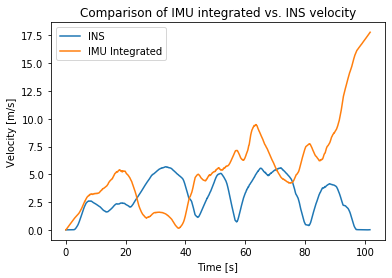

In [18]:
# Plot INS vs Imu Integrated velocity
plt.plot(ins_data.index,ins_data['.mag_speed'],label='INS')
plt.plot(imu_data.index,imu_vel,label="IMU Integrated")
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.title('Comparison of IMU integrated vs. INS velocity')

### Where does this drift come from?

Let's observe some acceleration data when the velocity of the golfcart is zero (observed when the magnitude of the GPS speed is < 0.01 m/s)

In [20]:
v_is_zero = ins_data['.mag_speed'] < 1e-2
v_is_zero = ins_data[v_is_zero]['.mag_speed'] >= 0.0
v_is_zero = v_is_zero.index[v_is_zero]

imu_when_zeroV = pandas.DataFrame(columns=imu_data.columns)
for t in v_is_zero:
    imu = imu_data.iloc[imu_data.index.get_loc(t,method='nearest')]
    imu_when_zeroV = imu_when_zeroV.append(imu)




imu_when_zeroV.describe()    

Stop Group #  1  Start Seq:  4966  End Seq:  5048


,.gps_time,.Mag.x,.Mag.y,.Mag.z,.Accel.x,.Accel.y,.Accel.z,.Gyro.x,.Gyro.y,.Gyro.z,.Temp,.Pressure,ins_vel
count,1.000000e+02,100.0,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.0,100.000000
mean,1.266946e+09,0.0,0.0,0.0,-0.312736,-0.153232,-9.766966,0.000067,-0.000003,-0.000015,0.0,0.0,0.008524
std,4.863606e+01,0.0,0.0,0.0,0.153943,0.157563,0.024637,0.001170,0.000860,0.000759,0.0,0.0,0.000777
min,1.266946e+09,0.0,0.0,0.0,-0.516115,-0.380444,-9.821852,-0.002065,-0.002715,-0.001544,0.0,0.0,0.006913
25%,1.266946e+09,0.0,0.0,0.0,-0.442355,-0.343320,-9.782477,-0.000827,-0.000449,-0.000582,0.0,0.0,0.008004
50%,1.266946e+09,0.0,0.0,0.0,-0.406985,-0.051076,-9.768445,0.000023,-0.000046,-0.000020,0.0,0.0,0.008487
75%,1.266946e+09,0.0,0.0,0.0,-0.132130,-0.023278,-9.753196,0.000847,0.000529,0.000545,0.0,0.0,0.008971
max,1.266946e+09,0.0,0.0,0.0,-0.086527,0.066165,-9.675923,0.003721,0.002181,0.002124,0.0,0.0,0.009981


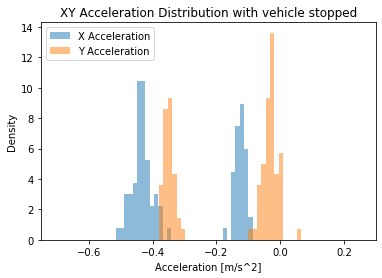

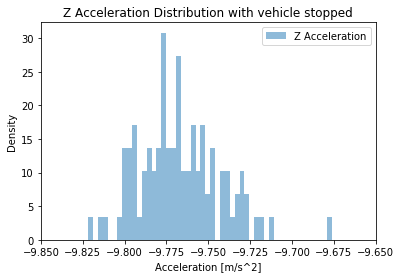

In [21]:
plt.figure()
plt.hist(imu_when_zeroV['.Accel.x'],bins=32,alpha=0.5,label="X Acceleration",density=True)
plt.hist(imu_when_zeroV['.Accel.y'],bins=32,alpha=0.5,label="Y Acceleration",density=True)
plt.xlim([-0.75,0.3])
plt.xlabel('Acceleration [m/s^2]')
plt.ylabel('Density')
plt.title('XY Acceleration Distribution with vehicle stopped')
plt.legend()
plt.figure()

plt.hist(imu_when_zeroV['.Accel.z'],bins=50,alpha=0.5,density=True,label="Z Acceleration")
plt.xlim([-9.85,-9.65])
plt.xlabel('Acceleration [m/s^2]')
plt.ylabel('Density')
plt.title('Z Acceleration Distribution with vehicle stopped')
plt.legend();

In [24]:
# Code accelerations by stop
imu_when_zeroV['group'] = None
c_time = imu_when_zeroV.index[0]
group = 0
for t in imu_when_zeroV.index:
    if np.abs(c_time - t) > 1: # Seperation time in seconds. Tune according to dataset
        group += 1
        c_time = t
    imu_when_zeroV.at[t,'group'] = group
    #print(t,group)
    #print(imu_when_zeroV)

for i in range(imu_when_zeroV['group'].max()):
    i +=1 # range gives 0 to n, need 1 to n
    seq = imu_when_zeroV[imu_when_zeroV['group']==i]['.header.seq']
    
    print("Stop Group # ",i," Start Seq: ",seq.min(), " End Seq: ",seq.max())

Stop Group #  1  Start Seq:  116  End Seq:  127
Stop Group #  2  Start Seq:  4966  End Seq:  5016
Stop Group #  3  Start Seq:  5017  End Seq:  5048


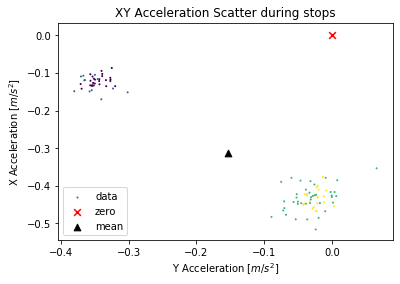

In [26]:
plt.title('XY Acceleration Scatter during stops')
plt.scatter(imu_when_zeroV['.Accel.y'],imu_when_zeroV['.Accel.x'],s=1,c=imu_when_zeroV['group'],label='data')
plt.scatter(0.0,0.0,s=45,color='red',label='zero',marker='x')
plt.scatter(imu_when_zeroV['.Accel.y'].mean(),imu_when_zeroV['.Accel.x'].mean(),s=45,marker='^',color='k',label='mean')
plt.xlabel('Y Acceleration [$m/s^2$]')
plt.ylabel('X Acceleration [$m/s^2$]');
plt.legend()

## Subtracting out the bias, and re-integrating

In [27]:
bx = imu_when_zeroV['.Accel.x'].mean()
by = imu_when_zeroV['.Accel.y'].mean()

# Perform integration, Initialize to ins_data[0]
imu_vel_x = np.asarray([ins_data['.NedVel.x'].iloc[0]])
imu_vel_y = np.asarray([ins_data['.NedVel.y'].iloc[0]])

for i in range(imu_data.index.size - 1):
    t0 = imu_data.index[i]
    t1 = imu_data.index[i+1]
    v_x0 = imu_data['.Accel.x'].iloc[i]  - bx
    v_y0 = imu_data['.Accel.y'].iloc[i]  - by
    vel_x = imu_vel_x[-1] + ( ((v_x0)*(t1-t0)))
    vel_y = imu_vel_y[-1] + ( ((v_y0)*(t1-t0))) 
    imu_vel_x = np.append(imu_vel_x,vel_x)
    imu_vel_y = np.append(imu_vel_y,vel_y)

imu_vel = (imu_vel_x**2 + imu_vel_y**2)**(1/2)

Text(0.5, 1.0, 'Comparison of IMU integrated vs. INS velocity')

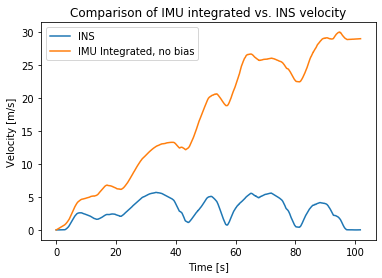

In [28]:
# Plot INS vs Imu Integrated velocity
plt.plot(ins_data.index,ins_data['.mag_speed'],label='INS')
plt.plot(imu_data.index,imu_vel,label="IMU Integrated, no bias")
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.title('Comparison of IMU integrated vs. INS velocity')

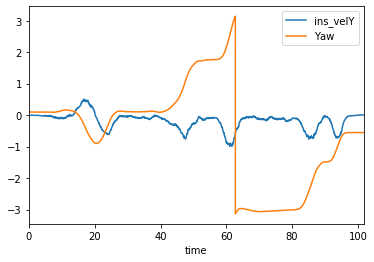

<Figure size 432x288 with 0 Axes>

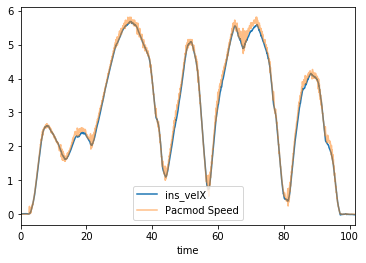

In [29]:
imu_data['ins_velX'] = 0.0
imu_data['ins_velY'] = 0.0
for t in imu_data.index:
    ct = ins_data.index.get_loc(t,method='nearest')
    imu_data.at[t,'ins_velX'] = ins_data.iloc[ct]['.LocalVel.x']
    imu_data.at[t,'ins_velY'] = ins_data.iloc[ct]['.LocalVel.y']
    

imu_data.plot(y='ins_velY')
plt.plot(ins_data.index.values,ins_data['.RPY.z'] * np.pi/180,label='Yaw')
plt.legend()

plt.figure()
imu_data.plot(y='ins_velX')
plt.plot(pacmod_speed['.data'],label='Pacmod Speed',alpha=0.5)
plt.legend()

Text(0.5, 1.0, 'Z Measurements (while stopped)')

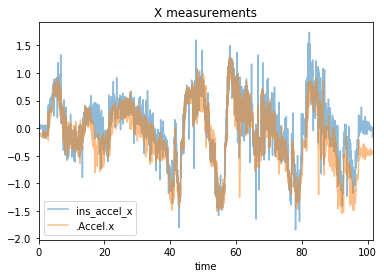

<Figure size 432x288 with 0 Axes>

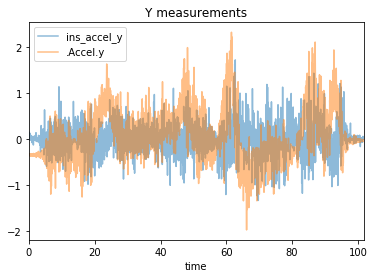

<Figure size 432x288 with 0 Axes>

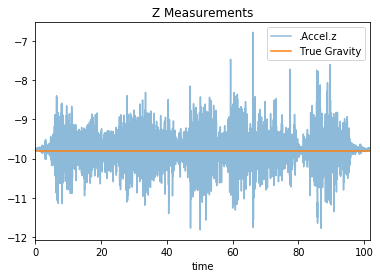

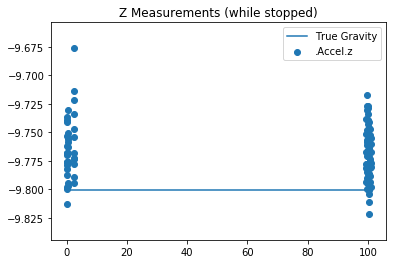

In [37]:
# Differentiate the INS velX and velY


imu_data['ins_accel_x'] = np.diff(imu_data['ins_velX'],prepend=1e-6)/np.diff(imu_data.index,prepend=1-7)
imu_data['ins_accel_y'] = np.diff(imu_data['ins_velY'],prepend=1e-6)/np.diff(imu_data.index,prepend=1-7)
imu_data.plot(y=['ins_accel_x','.Accel.x'],alpha=0.5)
plt.title('X measurements')


plt.figure()
imu_data.plot(y=['ins_accel_y','.Accel.y'],alpha=0.5)
plt.legend()
plt.title('Y measurements')

plt.figure()
imu_data.plot(y='.Accel.z',alpha=0.5)
plt.plot([0,700],[-9.801,-9.801],label='True Gravity')
plt.legend()
plt.title('Z Measurements')


plt.figure()
plt.scatter(x=imu_when_zeroV.index,y=imu_when_zeroV['.Accel.z'],label='.Accel.z')
plt.plot([0,100],[-9.801,-9.801],label='True Gravity')
plt.legend()
plt.title('Z Measurements (while stopped)')


In [83]:
import numpy.matlib
from scipy import integrate

def xyz_accel_scale_bias(C,B,imu_data_):
    """ Returns acceleration with scalefactor C and Bias B """
    imu_data_ = imu_data_.copy() # copy to avoid rewriting

    c_ = np.zeros((3,3))
    c_[0,0] = C[0]
    c_[1,1] = C[1]
    c_[2,2] = C[2]

    c_[0,1] = C[3]
    c_[0,2] = C[4]
    c_[1,2] = C[5]
    c_[1,0] = C[6]
    c_[2,0] = C[7]
    c_[2,1] = C[8]

    
    #print(c_)
    b_ = np.zeros((3,1))
    #print(b_)
    b_[0] = B[0]
    b_[1] = B[1]
    b_[2] = B[2]
    #print(b_)
    xyz_ = np.matmul(c_ ,( np.array([imu_data_['.Accel.x'],imu_data_['.Accel.y'],imu_data_['.Accel.z']]) + b_))
    #imu_data_[['.Accel.x','.Accel.y','.Accel.z']] = 0.0
    imu_data_[['.Accel.x','.Accel.y','.Accel.z']] = xyz_.T
    return imu_data_

def least_square_cost(imu_data_):
    diffx = (imu_data_['.Accel.x'] - imu_data_['ins_accel_x'] )**2 
    diffy = (imu_data_['.Accel.y'] - imu_data_['ins_accel_y'] )**2
    diffz = (imu_data_['.Accel.z'] - -9.801)**2 # 9.801 local gravity @ college station
    return np.sum(    (diffx + diffy + diffz)**(1/2)  )


def minimize_fun(theta):
    C = theta[0:9]
    B = theta[9:12]
#     print(C,B)
    new_imu_data = xyz_accel_scale_bias(C,B,imu_data)
    return least_square_cost(new_imu_data)

def integrate_imu_vel(imu_data_):
    imu_data_ = imu_data_.copy() # copy to avoid rewriting
    
    imu_data_['x_vel'] = integrate.cumtrapz(imu_data_['.Accel.x'],x=imu_data_.index,initial=ins_data['.LocalVel.x'][0])
    imu_data_['y_vel'] = integrate.cumtrapz(imu_data_['.Accel.y'],x=imu_data_.index,initial=ins_data['.LocalVel.y'][0])
    imu_data_['mag_vel'] = (imu_data_['x_vel']**2 + imu_data_['y_vel']**2)**(1/2)
    
    return imu_data_

print(minimize_fun([1,1,1,1,1,1,1,1,1,0,0,0]))
print(minimize_fun([1,1,1,1,1,1,1,1,1,0,0,0]))

71045.06929685101
71045.06929685101


In [88]:
import scipy.optimize
from scipy.optimize import Bounds


Bound = Bounds(lb=[0.9,0.9,0.9,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.2,-0.2,-0.2],ub=[1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,0.2,0.2,0.2])
sol = scipy.optimize.minimize(minimize_fun,[1,1,1,1,1,1,1,1,1,-0.1,0.0,0.1],bounds=Bound)
print(sol)

      fun: 3287.0502026524046
 hess_inv: <12x12 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.41155442e+02,  1.46515267e+03,  1.91833760e+02,  8.19500201e-01,
        3.41314899e+02,  2.85923516e+03,  1.40763223e+02, -2.20237780e+01,
       -1.33236426e+01, -3.09719326e+00, -2.60252727e+02,  8.08825916e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 637
      nit: 38
   status: 0
  success: True
        x: array([ 0.9       ,  0.9       ,  0.98114058,  0.05830019, -0.01084388,
        0.01488875, -0.10057408,  0.03238922, -0.07201705,  0.02513388,
        0.08974509, -0.19483683])


C = 
 [[ 0.9   0.06 -0.01]
 [-0.1   0.9   0.01]
 [ 0.03 -0.07  0.98]]
B = 
 [[ 0.03]
 [ 0.09]
 [-0.19]]


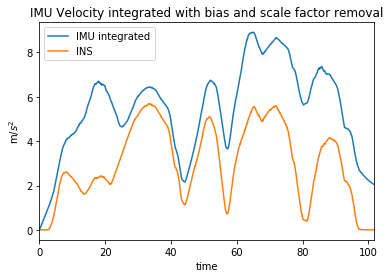

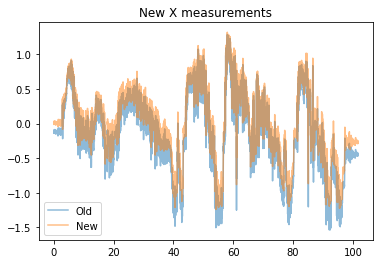

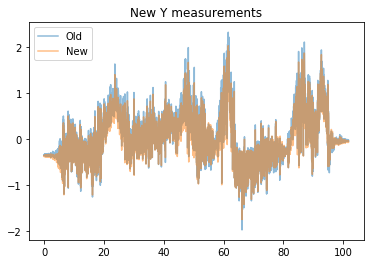

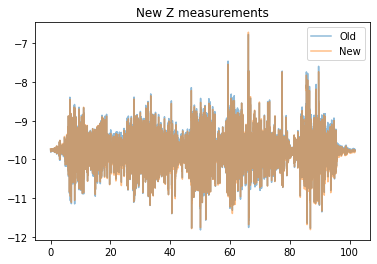

In [89]:
C = sol.x[0:9]
B = sol.x[9:12]

c_ = np.zeros((3,3))
c_[0,0] = C[0]
c_[1,1] = C[1]
c_[2,2] = C[2]

c_[0,1] = C[3]
c_[0,2] = C[4]
c_[1,2] = C[5]
c_[1,0] = C[6]
c_[2,0] = C[7]
c_[2,1] = C[8]

b_ = np.zeros((3,1))
b_[0] = B[0]
b_[1] = B[1]
b_[2] = B[2]
print("C = \n", np.array_str(c_, precision=2))
print("B = \n", np.array_str(b_, precision=2))


new_imu_data = xyz_accel_scale_bias(C,B,imu_data)
new_imu_data = integrate_imu_vel(new_imu_data)

new_imu_data.plot(y=['mag_vel','ins_vel'])
plt.legend(['IMU integrated','INS'])
plt.ylabel('m/$s^2$')
plt.title('IMU Velocity integrated with bias and scale factor removal')

plt.figure()
plt.plot(imu_data.index,imu_data['.Accel.x'],label='Old',alpha=0.5)
plt.plot(new_imu_data.index,new_imu_data['.Accel.x'],label='New',alpha=0.5)
plt.title('New X measurements')
plt.legend()


plt.figure()
plt.plot(imu_data.index,imu_data['.Accel.y'],label='Old',alpha=0.5)
plt.plot(new_imu_data.index,new_imu_data['.Accel.y'],label='New',alpha=0.5)
plt.title('New Y measurements')
plt.legend()


plt.figure()
plt.plot(imu_data.index,imu_data['.Accel.z'],label='Old',alpha=0.5)
plt.plot(new_imu_data.index,new_imu_data['.Accel.z'],label='New',alpha=0.5)
plt.title('New Z measurements')
plt.legend()

In [90]:
np.mean(new_imu_data['.Accel.z'])

-9.793790773575013